# WeatherPy


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from ratelimit import limits
import time
import json
import seaborn as sns
import logging
from datetime import date

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

617

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).

> **HINT:** The OpenWeatherMap API only allows 60 calls per minute under their free plan. Try using `time.sleep(60)` after each set of 50 cities to avoid API errors due to large calls.

In [3]:
# Setup API Calling
# url
url = "http://api.openweathermap.org/data/2.5/weather?"
# url = "https://openweathermap.org/api"

# units
unit = "units=Imperial"

# api
api = "&APPID=" + weather_api_key

# response 
response = requests.get( url + unit + api).json()

# print statement
print(response)


# Storage for api call data
city_info = {"City": [], 
             "Lat": [], 
             "Lng": [],
             "Max Temp": [],
             "Humidity": [],
             "Cloudiness": [],
             "Wind Speed": [],
             "Country": [], 
             "Date": []}

# hint, limit api calls
minute = 60
@limits(calls=60, period=minute)

# api call loop
def call_api():
    
    for i, city in enumerate(cities):
        city = requests.get(url + unit + "&q=" + cities[i] + api).json()
        
        try:
            print("Processing city " + str(i) + ": " + city["name"])
        
            city_info["City"].append(city["name"])
            city_info["Lat"].append(city["coord"]["lat"])
            city_info["Lng"].append(city["coord"]["lon"])
            city_info["Max Temp"].append(city["main"]["temp_max"])
            city_info["Humidity"].append(city["main"]["humidity"])
            city_info["Cloudiness"].append(city["clouds"]["all"])
            city_info["Wind Speed"].append(city["wind"]["speed"])
            city_info["Country"].append(city["sys"]["country"])
            city_info["Date"].append(city["dt"])
            
        except:
            print("Incomplete..., skip over missing city info.")
            pass
    print("Complete")
    
call_api()

# print log
logging.basicConfig(filename='api_print.log', filemode='w')
logging.warning('This data will be logged onto a file')


            
            
        

{'cod': '400', 'message': 'Nothing to geocode'}
Processing city 0: Airai
Processing city 1: Viedma
Processing city 2: Port Alfred
Processing city 3: Cayenne
Processing city 4: Opuwo
Processing city 5: Punta Arenas
Processing city 6: Ushuaia
Processing city 7: Yenagoa
Processing city 8: Norman Wells
Processing city 9: New Norfolk
Processing city 10: Ekangala
Processing city 11: Makkah al Mukarramah
Processing city 12: Ribeira Grande
Processing city 13: Bluff
Processing city 14: Saint Paul Harbor
Processing city 15: Severo-Kuril'sk
Processing city 16: Carnarvon
Processing city 17: Rikitea
Incomplete..., skip over missing city info.
Incomplete..., skip over missing city info.
Processing city 20: Busselton
Processing city 21: George Town
Processing city 22: Aracati
Incomplete..., skip over missing city info.
Processing city 24: Anadyr
Processing city 25: Itarema
Processing city 26: Barrow
Processing city 27: Tasiilaq
Processing city 28: Rawson
Processing city 29: Aklavik
Processing city 30

Processing city 261: Batagay
Processing city 262: Chumphon
Processing city 263: Ostrovnoy
Processing city 264: Poya
Incomplete..., skip over missing city info.
Processing city 266: Poum
Processing city 267: Gandajika
Processing city 268: Faanui
Processing city 269: Buraidah
Processing city 270: Nelson Bay
Processing city 271: Paso de los Toros
Processing city 272: Alyangula
Processing city 273: Naze
Processing city 274: Beidao
Processing city 275: Soke
Processing city 276: St. George's
Processing city 277: Yumen
Processing city 278: Lang Son
Processing city 279: Soyo
Processing city 280: Cilegon
Processing city 281: Mirebalais
Incomplete..., skip over missing city info.
Incomplete..., skip over missing city info.
Processing city 284: Mayumba
Processing city 285: Canby
Processing city 286: Leningradskiy
Processing city 287: Flinders
Processing city 288: Talavera de la Reina
Processing city 289: Conceição da Barra
Processing city 290: Buckeye
Processing city 291: Brezovo
Processing city 

Processing city 525: Beira
Processing city 526: Bonavista
Processing city 527: Alenquer
Processing city 528: Goderich
Processing city 529: Birao
Incomplete..., skip over missing city info.
Processing city 531: Salinas
Processing city 532: Toamasina
Processing city 533: Koson
Incomplete..., skip over missing city info.
Processing city 535: Matagami
Processing city 536: Ponta Delgada
Processing city 537: Tual
Processing city 538: Banda Aceh
Processing city 539: Rabo de Peixe
Processing city 540: Luís Correia
Processing city 541: Prince Rupert
Incomplete..., skip over missing city info.
Processing city 543: Motygino
Processing city 544: Bubaque
Processing city 545: Bolshoy Lug
Processing city 546: Huron
Processing city 547: Gobabis
Processing city 548: Barcarena
Processing city 549: Cologne
Processing city 550: Yerköy
Processing city 551: Kibala
Processing city 552: Champerico
Processing city 553: Aiken
Processing city 554: Vardø
Processing city 555: Bathsheba
Processing city 556: Valleyv

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
# Creating DataFrame
city_info_df = pd.DataFrame(city_info)

# Clean DataFrame
city_info_df["Max Temp"] = city_info_df["Max Temp"].replace('', np.nan)
city_info_df = city_info_df.dropna()

city_count = len(city_info_df)
# Export as CSV file
city_info_df.to_csv(output_data_file, index_label="City_ID")

In [5]:
# Inspect DataFrame
city_info_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Airai,-8.9266,125.4092,67.93,80,99,0.98,TL,1644451500
1,Viedma,-40.8135,-62.9967,82.04,37,94,6.08,AR,1644451501
2,Port Alfred,-33.5906,26.8910,65.64,85,5,9.98,ZA,1644451367
3,Cayenne,4.9333,-52.3333,76.08,91,75,1.01,GF,1644451275
4,Opuwo,-18.0607,13.8400,66.49,87,100,5.93,NA,1644451501
...,...,...,...,...,...,...,...,...,...
567,Qaqortoq,60.7167,-46.0333,16.30,71,95,9.95,GL,1644451639
568,Hastings,50.8552,0.5729,49.37,85,95,9.33,GB,1644451639
569,Plyussa,58.4308,29.3654,34.14,97,100,11.88,RU,1644451639
570,Quemado de Güines,22.7853,-80.2536,71.82,89,81,10.45,CU,1644451639


In [6]:
leftover_cities = city_info_df.loc[city_info_df["City"] != "Failed!"]
leftover_cities_count = len(leftover_cities)
print("{} number of cities were left out of the {} cities accounted for, giving a success rate of {:.1%} retrieval."
      .format(leftover_cities_count, city_count, (leftover_cities_count/city_count)))

leftover_cities.index = [a for a in range(leftover_cities_count)]

non_numeric_columns = ["City", "Country", "Date"]

for col in leftover_cities.columns:
    if(col not in non_numeric_columns):
        leftover_cities[col] = pd.to_numeric(leftover_cities[col])
        

leftover_cities

572 number of cities were left out of the 572 cities accounted for, giving a success rate of 100.0% retrieval.


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Airai,-8.9266,125.4092,67.93,80,99,0.98,TL,1644451500
1,Viedma,-40.8135,-62.9967,82.04,37,94,6.08,AR,1644451501
2,Port Alfred,-33.5906,26.8910,65.64,85,5,9.98,ZA,1644451367
3,Cayenne,4.9333,-52.3333,76.08,91,75,1.01,GF,1644451275
4,Opuwo,-18.0607,13.8400,66.49,87,100,5.93,NA,1644451501
...,...,...,...,...,...,...,...,...,...
567,Qaqortoq,60.7167,-46.0333,16.30,71,95,9.95,GL,1644451639
568,Hastings,50.8552,0.5729,49.37,85,95,9.33,GB,1644451639
569,Plyussa,58.4308,29.3654,34.14,97,100,11.88,RU,1644451639
570,Quemado de Güines,22.7853,-80.2536,71.82,89,81,10.45,CU,1644451639


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
# Table Columns
lat = city_info_df["Lat"]
max_temp = city_info_df["Max Temp"]
humidity = city_info_df["Humidity"]
cloudiness = city_info_df["Cloudiness"]
wind_speed = city_info_df["Wind Speed"]

In [8]:
#  Get the indices of cities that have humidity over 100%.
city_info_df["Humidity"]

0      80
1      37
2      85
3      91
4      87
       ..
567    71
568    85
569    97
570    89
571    26
Name: Humidity, Length: 572, dtype: int64

C:\Users\chris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Humidity'>

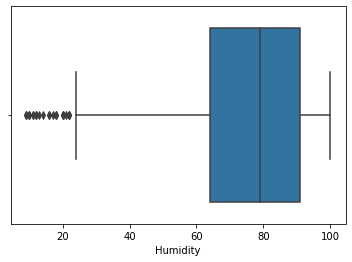

In [9]:
# Couldn't figure out how to use plot_filtered to fix FutureWarning
sns.boxplot(city_info_df["Humidity"])



In [10]:
# Print Outlier (if one exists)
print(np.where(city_info_df["Humidity"] > 100))
# Array is empty, no 'Humidity' over 100% exists in current dataset.

(array([], dtype=int64),)


#### Are There Any Cities With Humidity Over 100 % ?
From the results of the boxplot and the conditional print statement, there does not seem to be any cities within the dataset that has a humidity of over 100%.  

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Temperature vs Latitude Scatter Plot

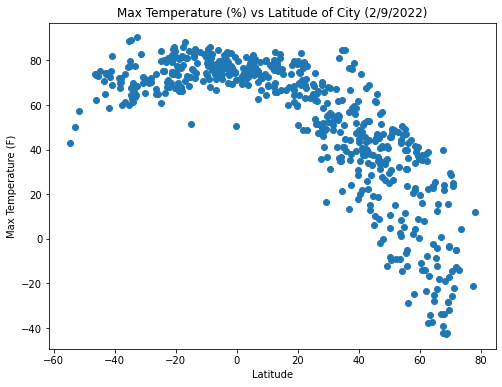

In [11]:
# Latitude vs Temperature
# viz config
plt.figure(figsize=(8,6))
lat_vs_temp = plt.scatter(lat, max_temp, linewidths=1, marker="o")

# titles & labels
plt.title("Max Temperature (%) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
# Display Plot
plt.show()

#### Temperature vs. Latitude Scatter Plot Analysis¶
The above scatter plot analyzies the latitudes of cities (north or south) of the equator against their correponding maximum temperatures (in degrees fahrenheit). Temperatures rise the closer a city is in relation to the equator. Cities south of the equator have higher maximum temperatures in comparison to cities north of the equator.  

In [12]:
# Save fig
lat_vs_temp.get_figure().savefig("../Images/Fig1.png")

## Humidity vs. Latitude Scatter Plot

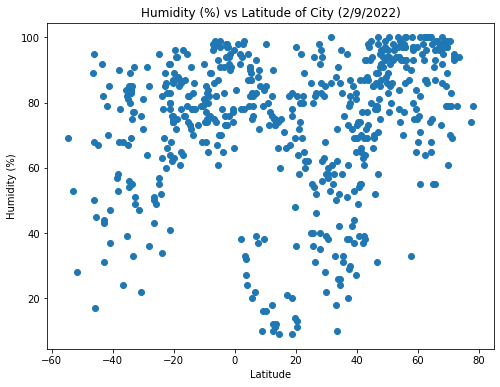

In [13]:
# Latitude vs Humidity
# viz config
plt.figure(figsize=(8,6))
lat_vs_humidity = plt.scatter(lat, humidity, linewidths=1, marker="o")

# titles & labels
plt.title("Humidity (%) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
# Display Plot
plt.show()

#### Humidity vs. Latitude Scatter Plot Analysis

The above scatter plot analyzies percent humidity against the latitudinal of a city in relation to the equator. There seems to be no apparently noticeable relationship between humidity and geolocation. 

In [14]:
lat_vs_humidity.get_figure().savefig("../Images/Fig2.png")

## Cloudiness vs. Latitude Scatter Plot

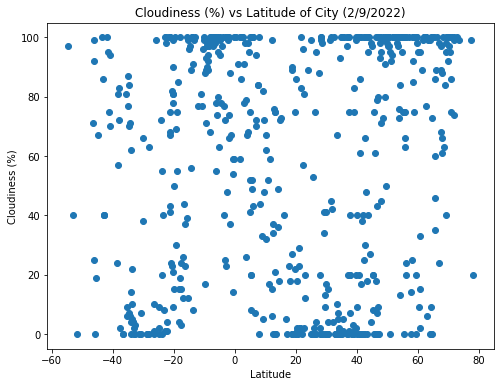

In [15]:
# Cloudiness vs. Latitude Scatter Plot
# viz config
plt.figure(figsize=(8,6))
lat_vs_cloudiness = plt.scatter(lat, cloudiness, linewidths=1, marker="o")

# titles & labels
plt.title("Cloudiness (%) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
# Display Plot
plt.show()

The scatter plot of Cloudiness vs. Latitude does does not show any associations between cloud cover and latitudial location.    

In [16]:
lat_vs_cloudiness.get_figure().savefig("../Images/Fig3.png")

## Wind Speed vs Latitude Scatter Plot

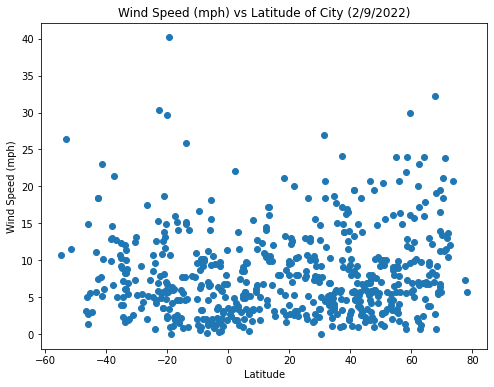

In [17]:
# Wind Speed vs Latitude Scatter Plot
# viz config
plt.figure(figsize=(8,6))
lat_vs_wind_speed = plt.scatter(lat, wind_speed, linewidths=1, marker="o")

# titles & labels
plt.title("Wind Speed (mph) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
# Display Plot
plt.show()

#### Wind Speed vs Latitude Scatter Plot Analysis
The Wind Speed vs Latitude Scatter Plot shows no apparent associations between wind speed and geolocation for cities north or south of the equator.

In [18]:
lat_vs_wind_speed.get_figure().savefig("../Images/Fig4.png")

## Linear Regression

In [19]:
# Linear Regression
def makeLinRegression(city_info_df, x_Col, y_Col):
    # preform linear regression
    (regr_slope, regr_intercept, regr_r_val, _, _) = linregress(city_info_df[x_Col], city_info_df[y_Col])
    # setup x and y axis data for linear regression 
    x = np.array([a for a in range(int(min(city_info_df[x_Col].values)), int(max(city_info_df[x_Col].values)+1))])
    y = regr_slope * x + regr_intercept
    # scatter plot
    axis_df = city_info_df.plot(kind="scatter", x=x_Col, y=y_Col, title="{} vs {} ({})")
    # best fit line
    axis_df.plot(x, y, 'r')
    
    # print statements
    print("Equation for best-fit linear regression line is y={:.2f}x+{:.2f}".format(regr_slope, regr_intercept))
    
    print("r-squared correlation coefficient is {:.2f}".format(regr_r_val))
    
    # return statement
    return axis_df

In [20]:
# Northern and Southern Hemispheres

# Northern Hemisphere DataFrame
northern_hemisphere = city_info_df.loc[city_info_df["Lat"] >= 0]
# Count of Cities in the Northern Hemisphere
northern_count = len(northern_hemisphere)
# Print 
print("The northern hemisphere has {} cities out of {} total, accounting for {:.1%} of cities in the dataset."
      .format(northern_count, city_count, (northern_count/city_count)))

# Southern Hemisphere DataFrame
southern_hemisphere = city_info_df.loc[city_info_df["Lat"] < 0]
# Count of Cities in the Southern Hemisphere
southern_count = len(southern_hemisphere)
# Print 
print("The southern hemisphere has {} cities out of {} total, accounting for {:.1%} of cities in the dataset."
      .format(southern_count, city_count, (southern_count/city_count)))

The northern hemisphere has 376 cities out of 572 total, accounting for 65.7% of cities in the dataset.
The southern hemisphere has 196 cities out of 572 total, accounting for 34.3% of cities in the dataset.


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

Line of Best-Fit for linear regression is y=-1.29x+90.80
The r-squared correlation coefficient is -0.82


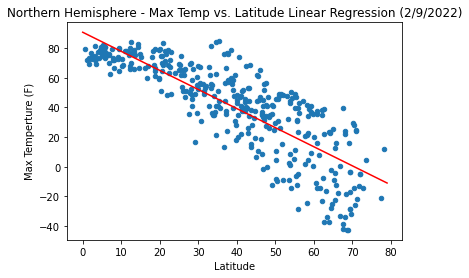

In [21]:
(n_temp_slope, n_temp_intercept, n_temp_r_val, _, _) = linregress(northern_hemisphere["Lat"],
                                                                 northern_hemisphere["Max Temp"])

x = np.array([a for a in range(80)])
y = n_temp_slope * x + n_temp_intercept

n_temp_axes = northern_hemisphere.plot(kind="scatter", x="Lat", y="Max Temp",
                                       title="Northern Hemisphere - Max Temp vs. Latitude Linear Regression (2/9/2022)")
# line of best fit
n_temp_axes.plot(x, y, 'r')

plt.xlabel("Latitude")
plt.ylabel("Max Temperture (F)")

# print 
print("Line of Best-Fit for linear regression is y={:.2f}x+{:.2f}"
      .format(n_temp_slope, n_temp_intercept))
print("The r-squared correlation coefficient is {:.2f}".format(n_temp_r_val))

# save figure as png
n_temp_axes.get_figure().savefig("../Images/Fig5_N.png")

#### Northern Hemisphere - Max Temp vs. Latitude Linear Regression Analysis

According to the linear regression of maximum temperature vs latitude for the cities in the northern hemisphere, there is a strong negative correlation. The farther away a city's geolocation is to the equator the colder the climate conditions.  

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.23x+78.95
r-squared correlation coefficient is 0.41


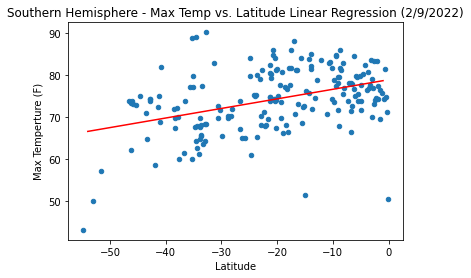

In [22]:
s_temp_axes = makeLinRegression(southern_hemisphere, "Lat", "Max Temp")
plt.title("Southern Hemisphere - Max Temp vs. Latitude Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Max Temperture (F)")
# save figure as png
s_temp_axes.get_figure().savefig("../Images/Fig6_S.png")

#### Southern Hemisphere - Max Temp vs. Latitude Linear Regression Analysis

The above linear regression shows a positive relationship between geolocation of cities in the southern hemisphere relative to the equator and their cooresopnding climate conditions. The cities closer to the equator enjoy warmer climate conditions and therefore higher maximum temperatures. 

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.45x+55.93
r-squared correlation coefficient is 0.38


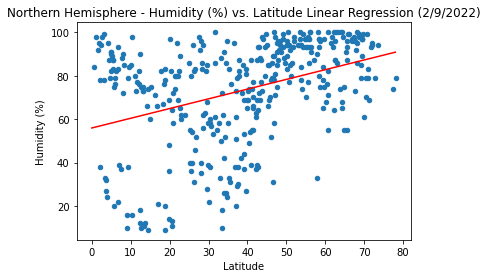

In [23]:
# Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
n_humidity_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Humidity")
plt.title("Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
# save figure as png
n_humidity_lat_axes.get_figure().savefig("../Images/Fig7_N.png")

#### Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression Analysis 
Dispite the somewhat positive correlation coefficient for the linear regression of Humidity (%) vs. Latitude for cities in the northern hemisphere, the outliers throughout makes the results for this particular dataset skewed. There should not be any noticable correlation between humidity for cities in respect to their geolocation from the equator. 

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.59x+86.75
r-squared correlation coefficient is 0.47


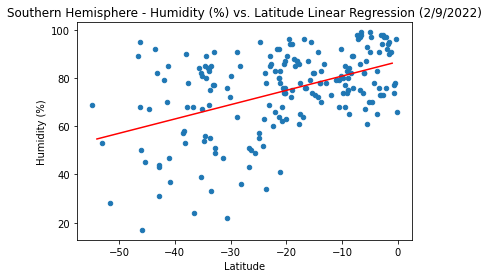

In [24]:
# Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
s_humidity_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Humidity")
plt.title("Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
# save figure as png
s_humidity_lat_axes.get_figure().savefig("../Images/Fig8_S.png")

#### Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression Analysis 
Likewise there should be little to no assoication between humidity and geolocation for cities in the southern hemisphere. 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.49x+37.07
r-squared correlation coefficient is 0.24


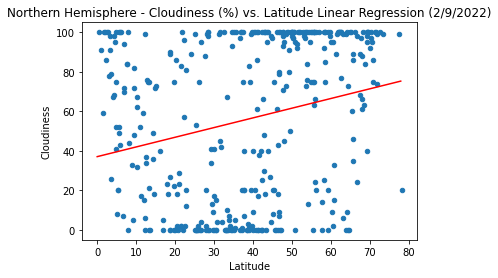

In [25]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
n_cloudiness_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Cloudiness")
plt.title("Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
# save figure as png
n_cloudiness_lat_axes.get_figure().savefig("../Images/Fig9_N.png")

#### Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression Analysis

Judging from the overall data spread, there should be little to no correlation between cloud coverage and geolocation for cities in the northern hemisphere. 

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=1.04x+79.50
r-squared correlation coefficient is 0.37


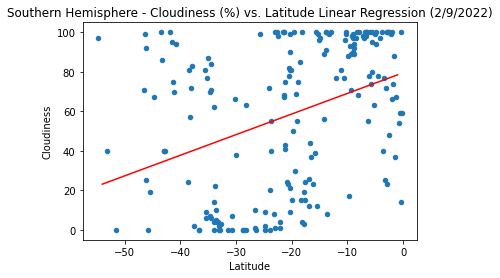

In [26]:
# Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
s_cloudiness_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Cloudiness")
plt.title("Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
# save figure as png
s_cloudiness_lat_axes.get_figure().savefig("../Images/Fig10_S.png")

#### Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression Analysis

Similarly, there should also be little to no correlation between cloud coverage and geolocation for cities in the southern hemisphere. 

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.05x+6.34
r-squared correlation coefficient is 0.18


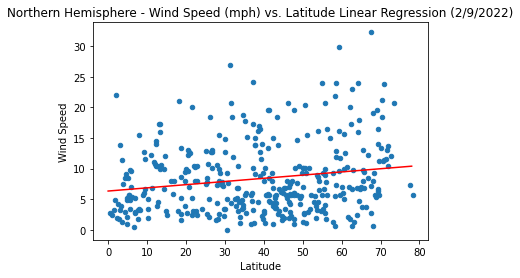

In [27]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
n_wind_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Wind Speed")
plt.title("Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
# save figure as png
n_wind_lat_axes.get_figure().savefig("../Images/Fig11_N.png")

According to the the correlation coefficient for the linear regression for Wind Speed (mph) vs. Latitude, there should be almost no or slightly weak positive correlation between wind speed and geolocation away from the equator. This data could be skewed by the outliers for a few very windy northern cities. 

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=-0.10x+5.69
r-squared correlation coefficient is -0.22


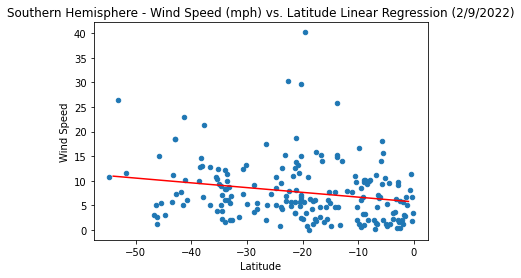

In [29]:
# Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
s_wind_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Wind Speed")
plt.title("Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
# save figure as png
s_wind_lat_axes.get_figure().savefig("../Images/Fig12_S.png")

#### Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression Analysis

Reasonably should also not be any association between wind speed and geolocation away from the equator for cities in the southern hemisphere.  

In [33]:
# outliers for observations 
print(np.where(city_info_df["Wind Speed"] > 30))

(array([ 44,  96, 548], dtype=int64),)


In [34]:
print(city_info_df.iloc[[44,  96, 548]])
# Outliers: Sørland (67.6670, 32.26), Isangel (40.18, -19.5500), Vao (-22.6667, 30.29) 

        City      Lat       Lng  Max Temp  Humidity  Cloudiness  Wind Speed  \
44   Isangel -19.5500  169.2667     77.61        96         100       40.18   
96       Vao -22.6667  167.4833     81.27        86         100       30.29   
548  Sørland  67.6670   12.6934     39.83        73          97       32.26   

    Country        Date  
44       VU  1644451323  
96       NC  1644451369  
548      NO  1644451634  
